In [1]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
from PIL import Image
import json
import matplotlib.pyplot as plt

In [3]:
model = models.resnet101(pretrained = True)
model.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

In [5]:
img = Image.open('./imagenet_samples/corgie.jpg')

In [6]:
img_transforms = transforms.Compose([transforms.Resize((224, 224), Image.BICUBIC), transforms.ToTensor(),])
img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)
print("Image Shape: ", img_tensor.size())

Image Shape:  torch.Size([1, 3, 224, 224])


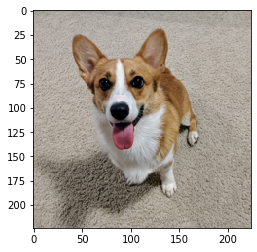

In [7]:
original_img_view = img_tensor.squeeze(0).detach()
original_img_view = original_img_view.transpose(0, 2).transpose(0, 1).numpy()
plt.imshow(original_img_view)

In [8]:
output = model(img_tensor)
prediction = output.max(1, keepdim = False)[1]
prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]
print("Predicted Label's Number: ", prediction_idx)
print("Label: ", prediction_name)

Predicted Label's Number:  263
Label:  Pembroke, Pembroke Welsh corgi


In [9]:
def fgsm_attack(image, epsilon, gradient):
    sign_gradient = gradient.sign()
    perturbed_image = image + epsilon * sign_gradient
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [10]:
img_tensor.requires_grad_(True)
output = model(img_tensor)
loss = F.nll_loss(output, torch.tensor([prediction_idx]))
model.zero_grad()
loss.backward()
gradient = img_tensor.grad.data

In [11]:
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)
output = model(perturbed_data)

In [12]:
perturbed_prediction = output.max(1, keepdim = True)[1]
perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]
print("Predicted Label's Number: ", prediction_idx)
print("Label: ", prediction_name)

Predicted Label's Number:  263
Label:  Pembroke, Pembroke Welsh corgi


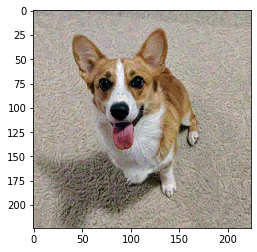

In [13]:
perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0, 2).transpose(0, 1).numpy()
plt.imshow(perturbed_data_view)

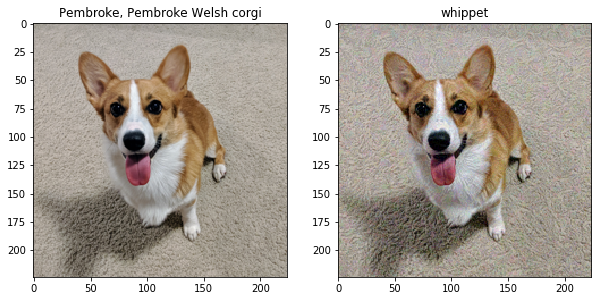

In [14]:
f, a = plt.subplots(1, 2, figsize = (10, 10))
a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)
plt.show()